# How much did the $>50$ keV electrons contribute to the atmospheric energy flux?

In [ ]:
import string

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors
import numpy as np
import pandas as pd
import re

import elfinasi

In [2]:
time_range = ('2022-09-04T04:18:00', '2022-09-04T04:23:00')
kev_erg_factor = 1.6E-9  # The conversion factor from KeV to ergs.
precipitation_solid_angle = 2*np.pi

## Load ELFIN and ASI inversion data

In [3]:
pad_obj_eflux = elfinasi.EPD_PAD(
    'a', time_range, start_pa=0, min_counts=None, accumulate=1, spin_time_tol=(2.5, 12),
    lc_exclusion_angle=10, nflux=False
)

C:\Users\shumkms1\Documents\research\elfinasi\src\elfinasi\elfin.py:839: UserWarning: The BLC/DLC ratios are all NaNs. This could be due to the lc_exclusion_angle excluding all pitch angles sampled.
  warnings.warn(


The THEMIS ASI inversion values were derived using the [Gabrielse+2021](https://doi.org/10.3389/fphy.2021.744298) algorithm.

In [6]:
inversion_dir = elfinasi.data_dir / '20220904_themis_asi_inversion'
_file_paths = sorted(inversion_dir.glob('ASIdata*'))

In [15]:
header = [
    "date/time", 
    "ELFINLat", 
    "PINALat", 
    "GILLlat", 
    "EFLINLon", 
    "PINALon", 
    "GILLlon", 
    "ClosestStation", 
    "Elevation [deg]",
    "ELFINeflux [erg/cm^2/s]", 
    "ELFINenergy [keV]"
    ]

In [18]:
themis_asi_eflux = pd.read_csv(
    elfinasi.data_dir / '20220904_themis_asi_inversion' / 'ASIdataCSV0.csv', 
    index_col=0, 
    skiprows=1,  # This is necessary because someone forgot to add ","s to the header!
    names=header,
    parse_dates=True, 
    na_values=('NaN', "-1")
)
themis_asi_eflux = themis_asi_eflux.loc[themis_asi_eflux['Elevation [deg]'] > 10]  # Christine's suggested threshold

In [19]:
themis_asi_eflux.dropna().head()

,ELFINLat,PINALat,GILLlat,EFLINLon,PINALon,GILLlon,ClosestStation,Elevation [deg],ELFINeflux [erg/cm^2/s],ELFINenergy [keV]
date/time,,,,,,,,,,
2022-09-04 04:19:42,58.188570,58.2521,58.1624,272.113669,271.991,272.152,gill,11.5868,0.050685,0.823
2022-09-04 04:19:43,58.123329,58.2521,58.1624,272.097144,271.991,272.152,gill,11.5868,0.050685,0.823
2022-09-04 04:19:44,58.058086,57.9534,58.0769,272.080665,272.228,272.167,gill,11.6890,0.113653,0.857
2022-09-04 04:19:45,57.993499,57.9534,58.0110,272.064065,272.228,272.012,gill,12.0754,0.144092,0.857
2022-09-04 04:19:46,57.927717,57.9534,57.9323,272.047807,272.228,272.046,gill,12.1287,0.191217,0.930


## Plot the ELFIN BLC and ABLC energy fluxes
Let's compare the amount of energy flux that disspiated in the atmosphere vs the amount that made it back out.

C:\Users\shumkms1\AppData\Local\Temp\ipykernel_11760\1964764843.py:19: RuntimeWarning: divide by zero encountered in divide
  pad_obj_eflux.blc.T/pad_obj_eflux.ablc.T,
C:\Users\shumkms1\AppData\Local\Temp\ipykernel_11760\1964764843.py:19: RuntimeWarning: invalid value encountered in divide
  pad_obj_eflux.blc.T/pad_obj_eflux.ablc.T,


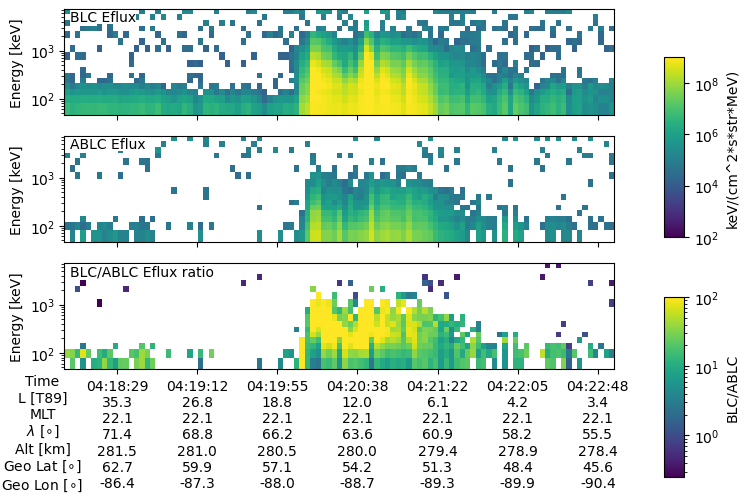

In [20]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
p = ax[0].pcolormesh(
            pad_obj_eflux.pad.time, 
            pad_obj_eflux.energy, 
            pad_obj_eflux.blc.T,
            shading='nearest',
            norm=matplotlib.colors.LogNorm(vmin=1E2, vmax=1E9)
            )
p2 = ax[1].pcolormesh(
            pad_obj_eflux.pad.time, 
            pad_obj_eflux.energy, 
            pad_obj_eflux.ablc.T,
            shading='nearest',
            norm=matplotlib.colors.LogNorm(vmin=1E2, vmax=1E9)
            )
p3 = ax[2].pcolormesh(
            pad_obj_eflux.pad.time, 
            pad_obj_eflux.energy, 
            pad_obj_eflux.blc.T/pad_obj_eflux.ablc.T,
            shading='nearest',
            norm=matplotlib.colors.LogNorm(vmax=10**2)
            )

pad_obj_eflux.plot_position(ax[-1])

labels = ('BLC Eflux', 'ABLC Eflux', 'BLC/ABLC Eflux ratio')
for ax_i, label in zip(ax, labels):
    ax_i.set_yscale('log')
    ax_i.set_ylabel('Energy [keV]')
    _text = ax_i.text(0.01, 0.99, label, transform=ax_i.transAxes, va='top')
    _text.set_bbox(dict(facecolor='white', linewidth=0, pad=0.1, edgecolor='k'))

fig.subplots_adjust(left=0.25, right=0.8)
cbar_ax0 = fig.add_axes([0.85, 0.5, 0.02, 0.3])
cbar_ax1 = fig.add_axes([0.85, 0.1, 0.02, 0.3])
fig.colorbar(p, cax=cbar_ax0, label=pad_obj_eflux._flux_units)
fig.colorbar(p3, cax=cbar_ax1, label='BLC/ABLC')

ax[-1].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[-1].xaxis.set_label_coords(-0.04, -0.007*7)
ax[-1].xaxis.label.set_size(10)


The bottom panel shows us that typically the precipitating energy flux was 10x-100x of the energy flux going back up. In other words, the $>50$ keV energy flux was mostly deposited into the atmosphere.

## What was the integrated $>50$ keV energy flux that ELFIN observed?

In [21]:
energy_widths_mev = (pad_obj_eflux.energy_widths[:, 1]-pad_obj_eflux.energy_widths[:, 0])/1E3
eflux_ergs = kev_erg_factor*precipitation_solid_angle*(pad_obj_eflux.blc - pad_obj_eflux.ablc)*energy_widths_mev
relativistic_eflux = np.nansum(eflux_ergs, axis=1)

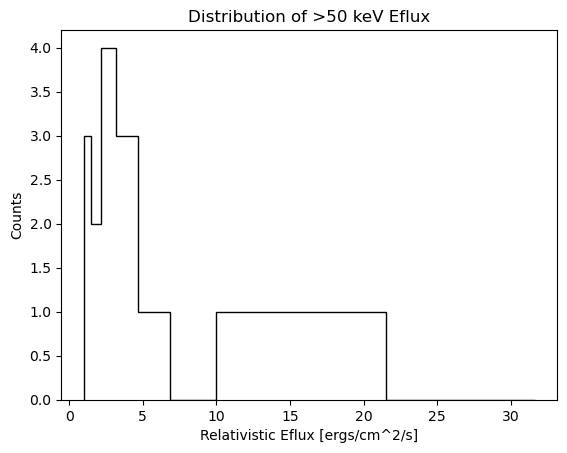

In [22]:
plt.hist(relativistic_eflux, bins=np.logspace(0, 1.5, 10), histtype='step', color='k')
plt.title('Distribution of >50 keV Eflux')
plt.xlabel('Relativistic Eflux [ergs/cm^2/s]')
plt.ylabel('Counts');

Looks good! Now let's merge the ELFIN and THEMIS-ASI Eflux values on the same time stamps and calculate the percentage contribution of the >50 keV electrons to the total energy flux

In [23]:
elfin_eflux = pd.DataFrame(relativistic_eflux, index=pad_obj_eflux.pad.time, columns=['energetic'])
auroral_eflux = pd.DataFrame(themis_asi_eflux['ELFINeflux [erg/cm^2/s]']).rename(columns={'ELFINeflux [erg/cm^2/s]':'auroral'})

merged_eflux = pd.merge_asof(
    elfin_eflux, 
    auroral_eflux, 
    left_index=True, 
    right_index=True, 
    direction='nearest', 
    tolerance=pd.Timedelta('1s')
    )
merged_eflux['energetic_contribution'] = 100*merged_eflux['energetic']/(merged_eflux['auroral'] + merged_eflux['energetic'])

In [24]:
merged_eflux

,energetic,auroral,energetic_contribution
2022-09-04 04:18:01.896945,0.006678,NaN,NaN
2022-09-04 04:18:04.762952,0.001689,NaN,NaN
2022-09-04 04:18:07.659442,0.001947,NaN,NaN
2022-09-04 04:18:10.525450,0.002996,NaN,NaN
2022-09-04 04:18:13.421940,0.004960,NaN,NaN
...,...,...,...
2022-09-04 04:22:44.012952,-0.003151,NaN,NaN
2022-09-04 04:22:46.887953,0.002618,NaN,NaN
2022-09-04 04:22:49.784443,0.001415,NaN,NaN
2022-09-04 04:22:52.650450,-0.002075,NaN,NaN


In [25]:
merged_eflux.dropna().describe().round(3)

,energetic,auroral,energetic_contribution
count,48.000,48.000,48.000
mean,1.340,7.054,9.090
std,3.338,10.350,13.850
min,-0.003,0.051,-1.869
25%,0.003,0.193,1.484
50%,0.015,0.539,4.266
75%,1.019,16.367,10.810
max,18.236,30.025,68.381


Note: the negative min energetic EFlux is a result of the space-time aliasing, with higher fluxes in the ABLC than the BLC during the ELFIN half-spin period

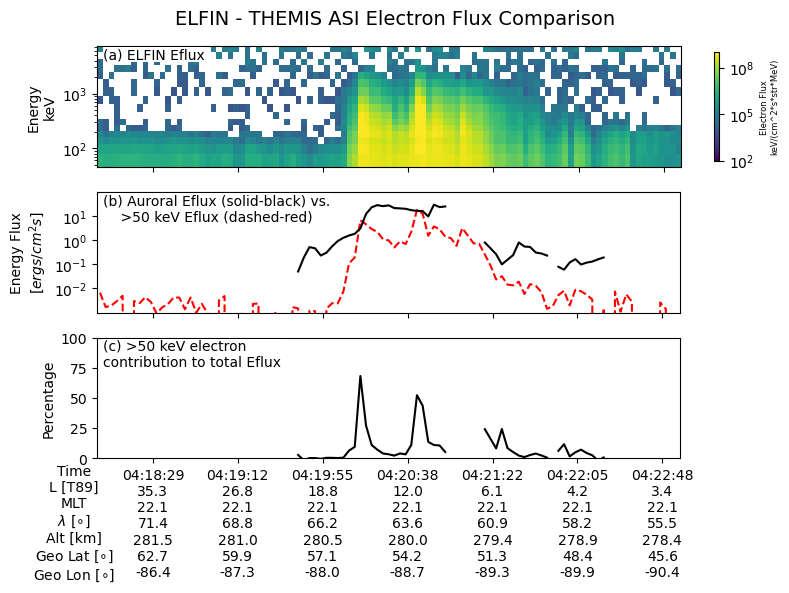

In [26]:
fig, bx = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
pad_obj_eflux.plot_omni(bx[0], labels=True, colorbar=True, vmin=1E2, vmax=1E9, pretty_plot=False, fraction=0.05)
bx[1].plot(
    merged_eflux.index, 
    merged_eflux['energetic'], 
    label='>50 keV Eflux (BLC-ABLC)', 
    color='r', 
    linestyle='--'
    )
bx[1].plot(
    merged_eflux.index, 
    merged_eflux['auroral'], 
    label='THEMIS ASI Eflux', color='k'
    )

bx[2].plot(merged_eflux.index, merged_eflux['energetic_contribution'], color='k')
pad_obj_eflux.plot_position(bx[-1])
bx[-1].xaxis.set_major_locator(plt.MaxNLocator(7))
bx[-1].xaxis.set_label_coords(-0.04, -0.007*7)
bx[-1].xaxis.label.set_size(10)

for bx_i in bx[[1, 2]]:
    divider = make_axes_locatable(bx_i)
    cax = divider.append_axes("right", size="10%", pad=0.08)
    cax.remove()

bx[1].set_yscale('log')
bx[1].set_ylabel(f'Energy Flux\n$[ergs/cm^{{2}}s]$')
bx[1].set_yticks([1E-2, 1E-1, 1E0, 1E1])
bx[1].set_ylim(1E-3, 1E2)

bx[2].set_ylabel(f'Percentage')
bx[2].set_ylim(0, 1E2)

labels = (
    'ELFIN Eflux', 
    'Auroral Eflux (solid-black) vs.\n    >50 keV Eflux (dashed-red)', 
    '>50 keV electron\ncontribution to total Eflux'
    )
for ax_i, label, letter in zip(bx, labels, string.ascii_lowercase):
    _text = ax_i.text(0.01, 0.99, f'({letter}) {label}', transform=ax_i.transAxes, va='top')
    _text.set_bbox(dict(facecolor='white', linewidth=0, pad=0.1, edgecolor='k'))
plt.suptitle('ELFIN - THEMIS ASI Electron Flux Comparison', fontsize=14)
plt.tight_layout()

Not a bad comparison considering that the [Gabrielse+2021](https://doi.org/10.3389/fphy.2021.744298) inversion for this event did not include the MSP data (those instruments stopped operating then). We should compare this with Calgary's inversion.

Two lessons learned from this first comparison:
1. Typically the energetic energy fluxes make up a small portion (4% median and 8% percent mean), and
2. Occasionally the energetic energy fluxes can make up as much as 68% of the energetic+auroral energy flux.

# Sensitivity Analysis

In [71]:
inversion_dir = elfinasi.data_dir / '20220904_themis_asi_inversion'
_file_paths = sorted(inversion_dir.glob('ASIdata*'))
offsets = [int(re.search(r"(\d{1,3})\.csv$", _file_path.name).group(1))/10 for _file_path in _file_paths]
sensitive_df = pd.DataFrame(
    index=offsets, 
    data={
        'file_name':[_file_path.name for _file_path in _file_paths],
        'median_energetic_contribution':-np.ones_like(_file_paths),
        'mean_energetic_contribution':-np.ones_like(_file_paths),
        'max_energetic_contribution':-np.ones_like(_file_paths),
        }
    )
sensitive_df = sensitive_df.sort_index()

In [72]:
for i, row in sensitive_df.iterrows():
    themis_asi_eflux = pd.read_csv(
        inversion_dir / row['file_name'], 
        index_col=0, 
        skiprows=1,  # This is necessary because someone forgot to add ","s to the header!
        names=header,
        parse_dates=True, 
        na_values=('NaN', "-1")
    )
    themis_asi_eflux = themis_asi_eflux.loc[themis_asi_eflux['Elevation [deg]'] > 10]  # Christine's suggested threshold

    elfin_eflux = pd.DataFrame(relativistic_eflux, index=pad_obj_eflux.pad.time, columns=['energetic'])
    auroral_eflux = pd.DataFrame(themis_asi_eflux['ELFINeflux [erg/cm^2/s]']).rename(columns={'ELFINeflux [erg/cm^2/s]':'auroral'})

    merged_eflux = pd.merge_asof(
        elfin_eflux, 
        auroral_eflux, 
        left_index=True, 
        right_index=True, 
        direction='nearest', 
        tolerance=pd.Timedelta('1s')
        )
    merged_eflux['energetic_contribution'] = 100*merged_eflux['energetic']/(merged_eflux['auroral'] + merged_eflux['energetic'])
    sensitive_df.loc[i, 'median_energetic_contribution'] = np.nanmedian(merged_eflux['energetic_contribution'])
    sensitive_df.loc[i, 'mean_energetic_contribution'] = np.nanmean(merged_eflux['energetic_contribution'])
    sensitive_df.loc[i, 'max_energetic_contribution'] = np.nanmax(merged_eflux['energetic_contribution'])

In [73]:
sensitive_df

,file_name,median_energetic_contribution,mean_energetic_contribution,max_energetic_contribution
0.0,ASIdataCSV0.csv,4.266172,9.089664,68.381455
0.5,ASIdataCSV5.csv,3.685512,8.176381,65.784603
1.0,ASIdataCSV10.csv,2.927503,6.444756,67.698792
1.5,ASIdataCSV15.csv,2.510225,5.742027,68.309756
2.0,ASIdataCSV20.csv,2.281519,5.141057,60.301949
2.5,ASIdataCSV25.csv,2.244332,5.52759,60.236676
3.0,ASIdataCSV30.csv,1.856528,5.7741,64.897744
3.5,ASIdataCSV35.csv,1.816211,5.857498,62.764642
4.0,ASIdataCSV40.csv,1.865545,5.823866,60.468228
4.5,ASIdataCSV45.csv,1.892202,5.491501,52.490034


Text(0.5, 1.0, '>50 keV Energy Flux Contribution to the total:\n$E_{>50 \\ keV}/(E_{THEMIS \\ ASI}+E_{>50 \\ keV})$')

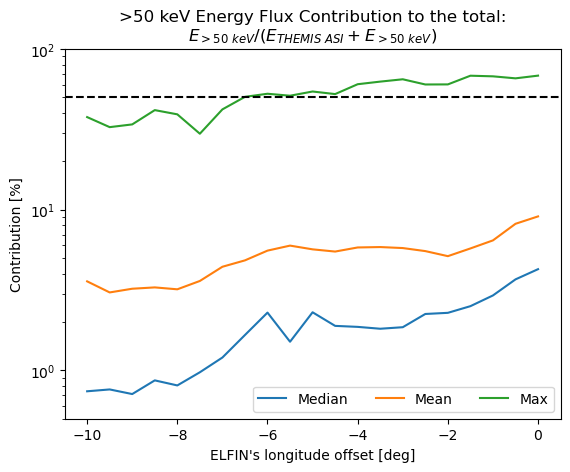

In [109]:
fig, bx = plt.subplots()
bx.plot(-sensitive_df.index, sensitive_df.loc[:, 'median_energetic_contribution'], label='Median')
bx.plot(-sensitive_df.index, sensitive_df.loc[:, 'mean_energetic_contribution'], label='Mean')
bx.plot(-sensitive_df.index, sensitive_df.loc[:, 'max_energetic_contribution'], label='Max')
bx.axhline(50, ls='--', c='k')
plt.legend(ncols=3, loc=4)
plt.yscale('log')
plt.ylim(5e-1, 1e2)
plt.ylabel('Contribution [%]')
plt.xlabel("ELFIN's longitude offset [deg]")
plt.title(f'>50 keV Energy Flux Contribution to the total:\n$E_{{>50 \ keV}}/(E_{{THEMIS \ ASI}}+E_{{>50 \ keV}})$')